In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2
import shutil
import torch
import os
from torch.utils.data import TensorDataset, DataLoader

In [2]:
train_images="data/VOC2012/JPEGImages/"
train_maps="data/VOC2012/Annotations/"

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

N_CLASSES=len(classes)
H,W=224,224
SPLIT_SIZE=int(H/32)
BATCH_SIZE=1

In [3]:
# This function preprocesses an XML file containing object detection annotations.
def preprocess_xml(filename):
    
    # Parse the XML file using ElementTree.
    tree = ET.parse(filename)
    root = tree.getroot()
    
    # Extract image size from the XML.
    size_tree = root.find('size')
    height = float(size_tree.find('height').text)
    width = float(size_tree.find('width').text)
    
    # Initialize list to store bounding boxes.
    bounding_boxes = []
    
    # Create a dictionary to map class names to indices.
    class_dict = {classes[i]: i for i in range(len(classes))}
    
    # Iterate through each object annotation in the XML.
    for object_tree in root.findall('object'):
        # Extract bounding box coordinates.
        for bounding_box in object_tree.iter('bndbox'):
            xmin = float(bounding_box.find('xmin').text)
            xmax = float(bounding_box.find('xmax').text)
            ymin = float(bounding_box.find('ymin').text)
            ymax = float(bounding_box.find('ymax').text)
            break
        
        # Extract class name of the object.
        class_name = object_tree.find('name').text
        
        # Calculate normalized bounding box coordinates and append to the list.
        bounding_box = [
            (xmin + xmax) / (2 * width),
            (ymin + ymax) / (2 * height),
            (xmax - xmin) / width,
            (ymax - ymin) / height,
            class_dict[class_name]
        ]
        bounding_boxes.append(bounding_box)
    
    # Convert the list of bounding boxes to a TensorFlow tensor and return.
    
    return torch.tensor(bounding_boxes)

In [4]:
def generate_output(bounding_boxes):
    # Initialize output label tensor
    output_label = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES + 5))

    # Iterate through bounding boxes
    for b in range(len(bounding_boxes)):
        # Calculate grid positions
        grid_x = bounding_boxes[..., b, 0] * SPLIT_SIZE
        grid_y = bounding_boxes[..., b, 1] * SPLIT_SIZE
        
        # Convert to integer grid indices
        i = int(grid_x)
        j = int(grid_y)

        # Assign values to output label tensor
        output_label[i, j, 0:5] = [1., grid_x % 1, grid_y % 1, bounding_boxes[..., b, 2], bounding_boxes[..., b, 3]]
        output_label[i, j, 5 + int(bounding_boxes[..., b, 4])] = 1.

    # Convert output label tensor to TensorFlow tensor
    
    return torch.tensor(output_label)
    

In [5]:
im_paths=[]
xml_paths=[]

for i in os.listdir(train_maps)[:5000]:
    im_paths.append(train_images+i[:-3]+'jpg')
    xml_paths.append(train_maps+i)

In [6]:
import torchvision.transforms as transforms
from PIL import Image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
])

images = []
for im_path in im_paths:
    # Open image using PIL
    img = Image.open(im_path).convert('RGB')
    
    # Apply transformations
    img_tensor = transform(img)
    
    images.append(img_tensor)

# Stack tensors
images = torch.stack(images)

In [7]:
boxes = []

for xml_path in xml_paths:
   
    boxes.append(generate_output(preprocess_xml(xml_path)))
    
print(boxes[0].dtype)
boxes = [tensor.float() for tensor in boxes]
print(boxes[0].dtype)
boxes = torch.stack(boxes)

torch.float64
torch.float32


In [8]:
import torch.nn as nn
import torchvision.models as models

NUM_FILTERS = 512
OUTPUT_DIM = int(N_CLASSES + 5)

# Load pre-trained ResNet50
base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Remove the last fully connected layer
base_model = nn.Sequential(*list(base_model.children())[:-2])

# Freeze the base model
for param in base_model.parameters():
    param.requires_grad = False


# Define additional layers
conv_layers = nn.Sequential(
    nn.Conv2d(2048, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1),
    
    nn.Conv2d(NUM_FILTERS, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1),
    
    nn.Conv2d(NUM_FILTERS, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1)
)

flatten = nn.Flatten()

dense_layers = nn.Sequential(
    nn.Linear(NUM_FILTERS * (H // 32) * (W // 32), NUM_FILTERS),
    nn.BatchNorm1d(NUM_FILTERS),
    nn.LeakyReLU(0.1),
    
    nn.Linear(NUM_FILTERS, int(SPLIT_SIZE * SPLIT_SIZE * OUTPUT_DIM)),
    nn.Sigmoid()
)

# Combine all layers into a single sequential model
model = nn.Sequential(
    base_model,
    conv_layers,
    flatten,
    dense_layers,
    nn.Unflatten(1, (SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM))
)

# Print model summary
print(model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [9]:
def difference(x, y):
    return torch.sum((y - x)**2)

def yolo_loss(y_true, y_pred):
    target = y_true[..., 0]  # Grid cell where we have information of object presence
    
    #--------------------------------------- for object
    
    target_indices = target == 1
    y_pred_extract = y_pred[target_indices]
    y_target_extract = y_true[target_indices]
    
    object_loss = difference(y_pred_extract[..., 0].float(), torch.ones_like(y_pred_extract[..., 0]).float())
    
    #------------------------------------------------------ for no object
    
    target_indices_no_obj = target == 0
    y_pred_extract_no_obj = y_pred[target_indices_no_obj]
    y_target_extract_no_obj = y_true[target_indices_no_obj]

    no_obj_loss = difference(y_pred_extract_no_obj[..., 0].float(), torch.zeros_like(y_pred_extract_no_obj[..., 0]).float())
    
    #-------------------------------------------------------- for object class loss
    
    y_pred_extract_class = y_pred[target_indices][:, 5:]
    class_extract = y_true[target_indices][:, 5:]
    
    class_loss = difference(y_pred_extract_class.float(), class_extract.float())
    
    #--------------------------------------------------------- for object center loss
    
    y_pred_extract_center = y_pred[target_indices][:, 1:3]
    center_target = y_true[target_indices][:, 1:3]
    
    center_loss = difference(y_pred_extract_center.float(), center_target.float())
    
    #------------------------------------------------------- for width and height
    
    size_pred = y_pred[target_indices][:, 3:5]
    size_target = y_true[target_indices][:, 3:5]
    
    size_loss = difference(torch.sqrt(torch.abs(size_pred.float())), torch.sqrt(torch.abs(size_target.float())))
    
    box_loss = center_loss + size_loss
    
    lambda_coord = 5
    lambda_no_obj = 0.5
    
    loss = object_loss + (lambda_no_obj * no_obj_loss) + lambda_coord * box_loss + class_loss
    
    return loss

In [10]:
# Move model and data to MPS device
device = "cuda"
model.to(device)
images = images.to(device)
boxes = boxes.to(device)


# Define your loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Assuming batch size of 32 and iterating through batches
    batch_size = 32
    for i in range(0, len(images), batch_size):
        img_batch = images[i:i+batch_size]
        target_batch = boxes[i:i+batch_size]

        # Forward pass
        outputs = model(img_batch)

        # Assuming you have a custom YOLO-like loss function
        loss = yolo_loss(target_batch,outputs)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / (len(images) / batch_size)}')

print('Finished Training')

Epoch [1/50], Loss: 200.08933874511717
Epoch [2/50], Loss: 152.25857717285157
Epoch [3/50], Loss: 131.2893474609375
Epoch [4/50], Loss: 109.92436870117187
Epoch [5/50], Loss: 93.1819899169922
Epoch [6/50], Loss: 81.12142953491211
Epoch [7/50], Loss: 68.7674265991211
Epoch [8/50], Loss: 57.12876752929687
Epoch [9/50], Loss: 47.610303424072264
Epoch [10/50], Loss: 40.506288250732425
Epoch [11/50], Loss: 34.25611965942383
Epoch [12/50], Loss: 29.22947626647949
Epoch [13/50], Loss: 25.198014712524415
Epoch [14/50], Loss: 22.52811019897461
Epoch [15/50], Loss: 20.39193844604492
Epoch [16/50], Loss: 19.244472286987303
Epoch [17/50], Loss: 18.03386562194824
Epoch [18/50], Loss: 17.202987316894532
Epoch [19/50], Loss: 16.477097509765624
Epoch [20/50], Loss: 15.604944750976562
Epoch [21/50], Loss: 14.42144231414795
Epoch [22/50], Loss: 13.382454672241211
Epoch [23/50], Loss: 12.395246533203125
Epoch [24/50], Loss: 11.91943690032959
Epoch [25/50], Loss: 11.428518952941895
Epoch [26/50], Loss: 11

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


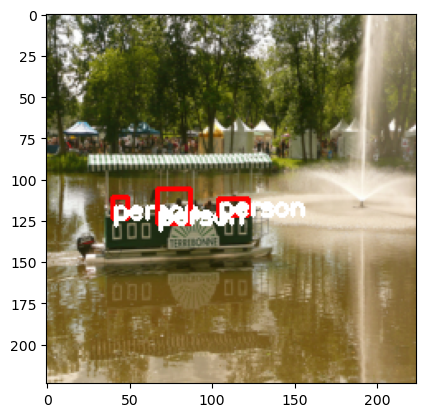

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


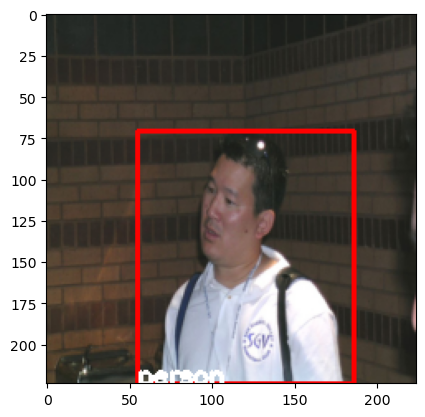

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


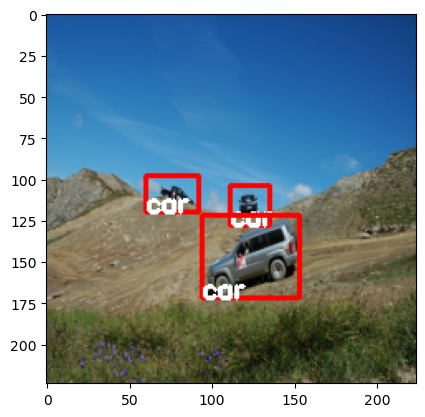

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


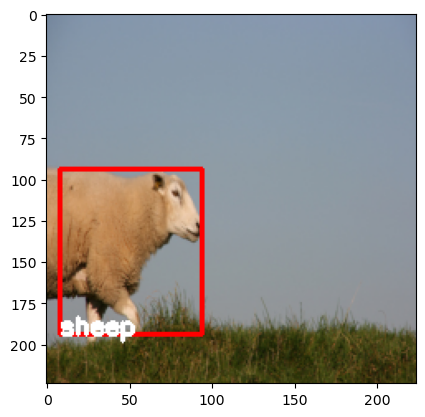

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


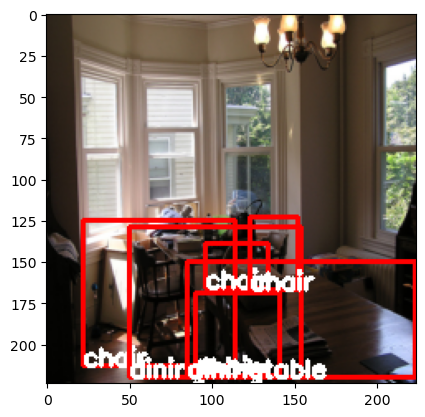

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


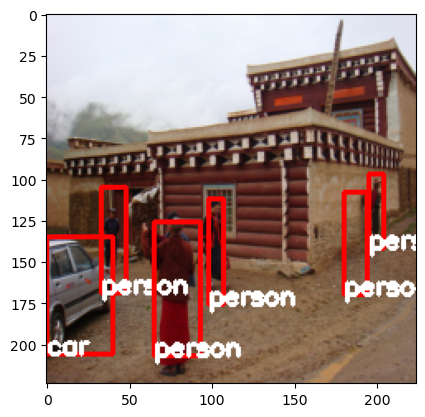

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


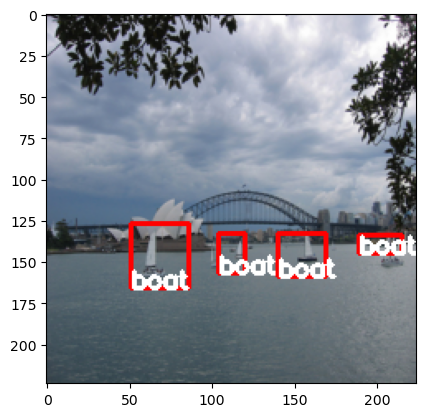

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


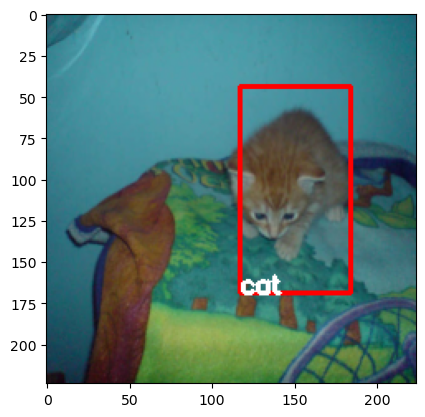

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


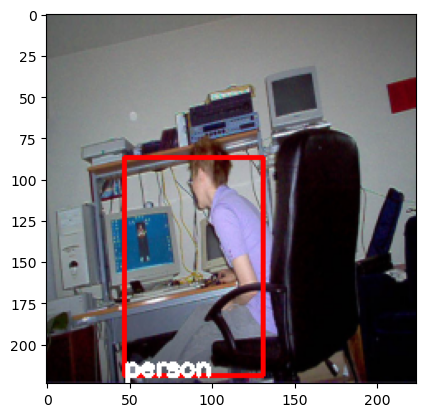

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


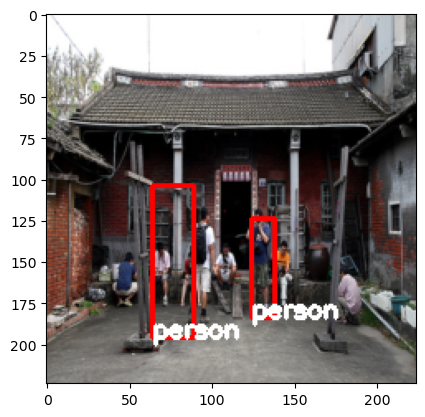

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


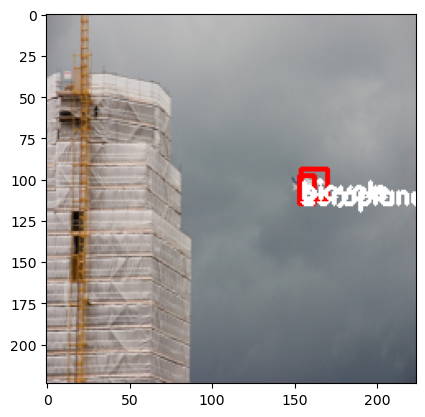

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


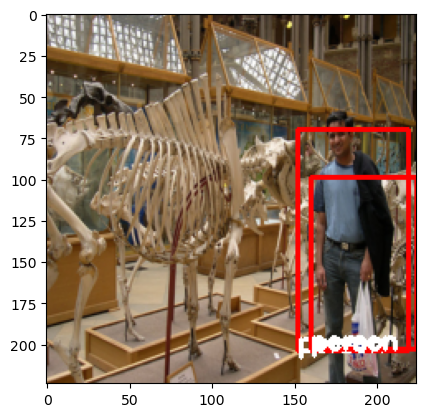

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


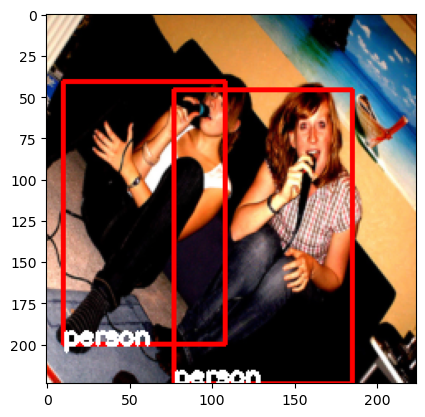

In [12]:
for j in [60,10,5,4,3416,500,600,800,560,1000,595,1400,1657]:
    
    output = model(images[j:j+32])[:1] #SINCE MODEL TAKES 32 AS BATCH AND NOT SINGLE IMAGE

    # Threshold for detection
    THRESH = 0.25

    # Get object positions
    object_positions = torch.where(output[..., 0] >= THRESH)
    selected_output = output[object_positions]

    # Initialize lists for final boxes and scores
    final_boxes = []
    final_scores = []

    # Iterate through object positions
    for i in range(len(object_positions[0])):
        if selected_output[i][0] > THRESH:
            # Extract box parameters
            output_box = selected_output[i][1:5].float()
            x_centre = (object_positions[1][i] + output_box[0]) * 32
            y_centre = (object_positions[2][i] + output_box[1]) * 32
            x_width, y_height = torch.abs(224 * output_box[2]), torch.abs(224 * output_box[3])
            x_min, y_min = int(x_centre - (x_width / 2)), int(y_centre - (y_height / 2))
            x_max, y_max = int(x_centre + (x_width / 2)), int(y_centre + (y_height / 2))

            # Adjust bounding box coordinates
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(224, x_max)
            y_max = min(224, y_max)

            # Append to final boxes
            final_boxes.append([x_min, y_min, x_max, y_max, 
                               classes[torch.argmax(selected_output[i][5:]).item()]])
            final_scores.append(selected_output[i][0].item())


    img = np.array(images[j].permute(1, 2, 0).to('cpu')).copy()
    
    for i in range(len(final_boxes)):

        # Extract object classes and boxes
        object_classes = final_boxes[i][4]
        nms_output = final_boxes[i][0:4]

        x1, y1 = nms_output[:2]
        x2, y2 = nms_output[2:]

        # Specify the color (in BGR format) and thickness
        color = (255, 0, 0) 
        thickness = 2

        # Draw the rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        
        # Add text (object classes) 
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 255, 255)  
        text_position = (x1, y2)  

        cv2.putText(img, object_classes, text_position, font, font_scale, font_color, thickness)
    plt.imshow(img)
    plt.show()